In [131]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as ply
%matplotlib inline

In [132]:
file_classes = ['dogs', 'cats']

In [133]:
train_path = 'Projects/keras/cats-and-dogs/train'
valid_path = 'Projects/keras/cats-and-dogs/valid'
test_path = 'Projects/keras/cats-and-dogs/test'

In [134]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=file_classes, batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=file_classes, batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=file_classes, batch_size=8)

Found 113 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [135]:
def plots (ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
            
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [136]:
imgs, labels = next(train_batches)

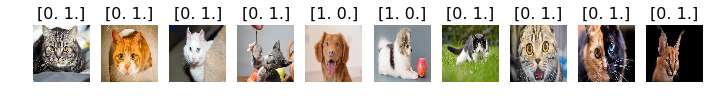

In [137]:
plots(imgs, titles=labels)

# Build Fine-tuned VGG16 Model

In [138]:
vgg16_model = keras.applications.vgg16.VGG16()

In [139]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [140]:
type(vgg16_model)

keras.engine.training.Model

In [141]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

We remove the last 'predictions' layer (Using [:-1]) as model.layers.pop() does not work

NOTE: We can also add the argument "include_top=False" in the import.

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [143]:
# model.layers.pop()

In [144]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [145]:
for layer in model.layers:
    layer.trainable = False

In [146]:
model.add(Dense(len(file_classes), activation='softmax'))

In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Train the Fine-tuned VGG16 Model

In [148]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
model.fit_generator(train_batches, steps_per_epoch=4,
                    validation_data=valid_batches, validation_steps=4, epochs=10, verbose=2)

Epoch 1/10
 - 38s - loss: 0.6986 - acc: 0.6000 - val_loss: 0.7755 - val_acc: 0.7500
Epoch 2/10
 - 38s - loss: 0.7306 - acc: 0.7750 - val_loss: 0.4501 - val_acc: 0.8750
Epoch 3/10
 - 33s - loss: 0.4147 - acc: 0.7970 - val_loss: 0.2534 - val_acc: 0.9375
Epoch 4/10
 - 37s - loss: 0.4283 - acc: 0.8500 - val_loss: 0.6165 - val_acc: 0.8750
Epoch 5/10
 - 33s - loss: 0.3483 - acc: 0.8750 - val_loss: 0.6483 - val_acc: 0.7500
Epoch 6/10
 - 29s - loss: 0.4187 - acc: 0.8491 - val_loss: 0.5353 - val_acc: 0.6875
Epoch 7/10
 - 32s - loss: 0.4400 - acc: 0.9000 - val_loss: 0.4160 - val_acc: 0.8750
Epoch 8/10
 - 32s - loss: 0.1339 - acc: 0.9250 - val_loss: 0.0489 - val_acc: 1.0000
Epoch 9/10
 - 27s - loss: 0.1791 - acc: 0.9218 - val_loss: 0.0231 - val_acc: 1.0000
Epoch 10/10
 - 36s - loss: 0.2293 - acc: 0.9500 - val_loss: 0.1938 - val_acc: 0.8750


# Predicting with VGG16

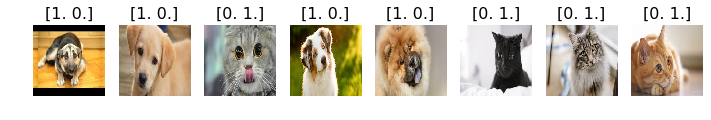

In [150]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [151]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 1., 1., 0., 0., 0.], dtype=float32)

In [152]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
predictions

array([[1.64817247e-04, 9.99835134e-01],
       [9.99858141e-01, 1.41788056e-04],
       [1.22876257e-01, 8.77123773e-01],
       [9.83463824e-01, 1.65362321e-02],
       [4.47621718e-02, 9.55237806e-01],
       [1.23661034e-01, 8.76339018e-01],
       [8.54354352e-03, 9.91456449e-01],
       [8.42505172e-02, 9.15749490e-01]], dtype=float32)

In [153]:
test_batches.class_indices

{'dogs': 0, 'cats': 1}

In [154]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

In [155]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4 0]
 [2 2]]


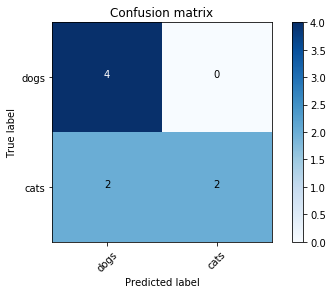

In [156]:
plot_confusion_matrix(cm, file_classes)

# Augment Data

In [157]:
import matplotlib.pyplot as plt
from scipy import misc, ndimage

In [158]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                        height_shift_range=0.1, shear_range=0.25,
                        zoom_range=0.1, channel_shift_range=10,
                        horizontal_flip=True)

c:\users\aranm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


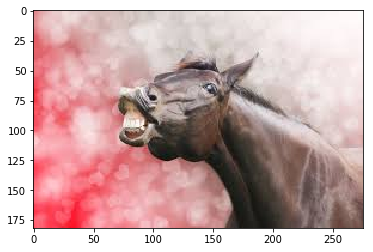

In [159]:
image_path = 'Projects/keras/cats-and-dogs/valid/horses/images (41).jpg'

image = np.expand_dims(ndimage.imread(image_path), 0)
plt.imshow(image[0])

aug_itr = gen.flow(image)
aug_image = [next(aug_itr)[0].astype(np.uint8) for i in range(10)]

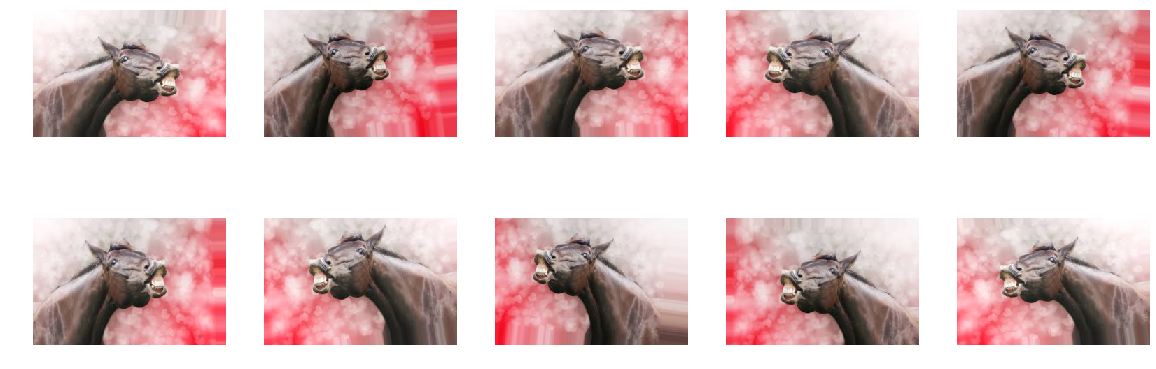

In [160]:
plots(aug_image, figsize=(20,7), rows=2)

In [161]:
model.save_weights('VGG16_cats_dogs_horses')